# IV. Trend Prediction

## 1. Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# For LSTM model
from keras.models import Model
from keras.layers import Dense, LSTM, Input
from keras.callbacks import EarlyStopping

# To evaluate the models
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 2. Loading processed data

In [2]:
df = pd.read_csv("crude_oil_prices.csv", index_col="date")
data = df["prices (Dollars per Barrel)"]
data.index = pd.DatetimeIndex(data.index).to_period('B').to_timestamp()  # Sets the frequency for the time series.
data

C:\Users\PC\AppData\Local\Temp\ipykernel_10724\3130949942.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index = pd.DatetimeIndex(data.index).to_period('B').to_timestamp()  # Sets the frequency for the time series.


date
1987-05-20    18.63
1987-05-21    18.45
1987-05-22    18.55
1987-05-25    18.60
1987-05-26    18.63
              ...  
2024-06-12    80.52
2024-06-13    81.44
2024-06-14    81.49
2024-06-17    82.45
2024-06-18    84.79
Name: prices (Dollars per Barrel), Length: 9409, dtype: float64

## 3. Set hyperparameters

In [3]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 120
timesteps = 30

## 4. Splitting and Normalize dataset

In [5]:
#get the length of training data set 
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

length = get_train_length(data, batch_size, 0.1)
#Adding timesteps * 2
upper_train = length + timesteps*2
dataset = data[0:upper_train]
dataset = dataset.to_frame()
training_set = dataset.iloc[:,0:1].values
training_set.shape

8384
8448


(8508, 1)

In [8]:
# Feature Scaling i.e we scale each and every value between 0 and 1 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape
X_train = []
y_train = []

# Creating a data structure with n timesteps

for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])


# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(8448, 30, 1)
(8448, 30, 1)


In [11]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))
test_length = get_test_length(data, batch_size)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train

9212
9276
9340
9340


In [13]:
#subsetting
data_test = data[upper_train:upper_test] 
data_test = data_test.to_frame()
test_set = data_test.iloc[:,0:1].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## 5. Build LSTM model

In [9]:
inputs_1_mae = Input(batch_shape=(batch_size, timesteps, 1))

# Add stateful LSTM layers
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

# Output layer
output_1_mae = Dense(units=1)(lstm_2_mae)

# Instantiate the model
regressor_mae = Model(inputs=inputs_1_mae, outputs=output_1_mae)

# Compile the model with Adam optimizer and mean absolute error as the loss function
regressor_mae.compile(optimizer='adam', loss='mae')

# Print model summary to verify the architecture
regressor_mae.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(64, 30, 1)]             0         
                                                                 
 lstm (LSTM)                 (64, 30, 10)              480       
                                                                 
 lstm_1 (LSTM)               (64, 30, 10)              840       
                                                                 
 dense (Dense)               (64, 30, 1)               11        
                                                                 
Total params: 1331 (5.20 KB)
Trainable params: 1331 (5.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
for i in range(epochs):
    print("Epoch: " + str(i))
    history = regressor_mae.fit(X_train, y_train, shuffle=False, epochs=1, batch_size=batch_size, callbacks=[early_stopping])    
    for layer in regressor_mae.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()
    
    # Check if early stopping was triggered
    if early_stopping.stopped_epoch > 0:
        print("Early stopping triggered after epoch: ", early_stopping.stopped_epoch)
        break

Epoch: 0

132/132 [==============================] - 7s 18ms/step - loss: 0.0545
Epoch: 1
132/132 [==============================] - 3s 20ms/step - loss: 0.0703
Epoch: 2
132/132 [==============================] - 3s 24ms/step - loss: 0.0641
Epoch: 3
132/132 [==============================] - 3s 21ms/step - loss: 0.0618
Epoch: 4
132/132 [==============================] - 3s 23ms/step - loss: 0.0593
Epoch: 5
132/132 [==============================] - 3s 19ms/step - loss: 0.0569
Epoch: 6
132/132 [==============================] - 3s 19ms/step - loss: 0.0543
Epoch: 7
132/132 [==============================] - 2s 17ms/step - loss: 0.0516
Epoch: 8
132/132 [==============================] - 2s 19ms/step - loss: 0.0490
Epoch: 9
132/132 [==============================] - 2s 17ms/step - loss: 0.0466
Epoch: 10
132/132 [==============================] - 5s 36ms/step - loss: 0.0452
Epoch: 11
132/132 [==============================] - 3s 19ms/step - loss: 0.0442
Epoch: 12
132/132 [==================

In [14]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
for layer in regressor_mae.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))


13/13 [==============================] - 1s 10ms/step
(832, 30, 1)
(832, 30)
(802, 1)


## 5. Model Testing

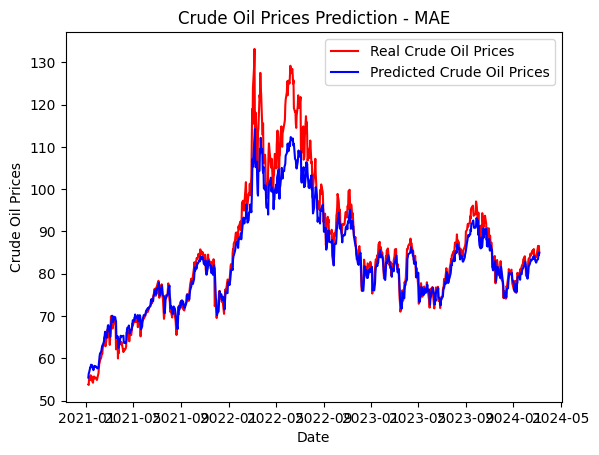

In [15]:
# Convert y_test to a pandas Series with the same index as data_test
y_test_series = pd.Series(y_test.flatten(), index=data_test.index[timesteps:timesteps+len(y_test)])

# Visualising the results
plt.plot(data_test.index[timesteps:timesteps+len(y_test)], test_set[timesteps:timesteps+len(y_test)], color='red', label='Real Crude Oil Prices')
plt.plot(y_test_series.index, y_test_series, color='blue', label='Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Date')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

**Evaluation**
1. Model Performance:
- The LSTM model shows a good ability to capture the long-term trends and major movements in the crude oil prices.
- The slight deviations and lag indicate areas where the model could potentially be improved, such as incorporating additional features or using more sophisticated modeling techniques.
2. Evaluation Metrics: While the visual inspection provides a good qualitative assessment, quantitative metrics like RMSE, MAE, and MAPE will provide a more precise evaluation of the model's performance.
Lower values of these metrics indicate better predictive accuracy.

In summary, the LSTM model provides a solid foundation for predicting crude oil prices, capturing the general trends and significant movements. 

## 6. Model Evaluation

In [28]:
# Making predictions on the test set
prediction_set = []
train_data_lstm = training_set_scaled[-timesteps:]
new_batch = train_data_lstm.reshape((1, timesteps, 1))

for i in range(len(scaled_real_bcg_values_test)):
    pred = regressor_mae.predict(new_batch, batch_size=batch_size, verbose=False)
    prediction_set.append(pred[0, -1])
    new_batch = np.append(new_batch[:, 1:, :], np.reshape(pred[0, -1], (1, 1, 1)), axis=1)

prediction_set = [i[0] for i in prediction_set]  # Transforms a list of arrays into a list of single float items.
predictions = pd.Series(sc.inverse_transform(np.array(prediction_set).reshape(-1, 1)).flatten(), index=data_test.index)

# Calculate evaluation metrics
y_true = test_set
y_pred = predictions.values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Create a DataFrame to show the results
metrics_df = pd.DataFrame({
    'RMSE': [rmse],
    'MAE': [mae],
    'MAPE': [mape]
})

print(metrics_df)

       RMSE        MAE       MAPE
0  17.67025  13.163977  15.281455


#### Using the model to forecast the Brent crude oil price for the following 30 days

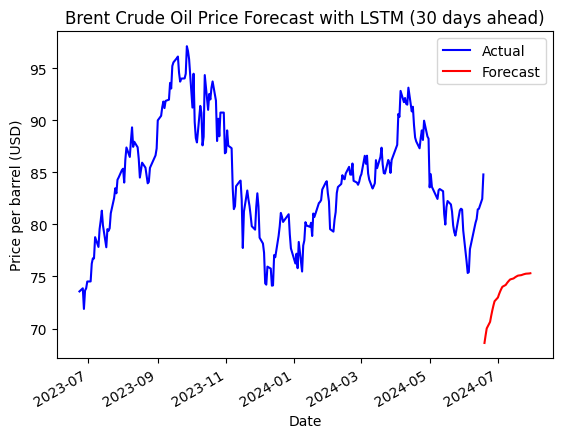

In [21]:
# Predicting the next 365 days
full_data_lstm = training_set_scaled
batch_one = full_data_lstm[-timesteps:]
new_batch = batch_one.reshape((1, timesteps, 1))
days_to_forecast = 30

prediction_set = []
for i in range(days_to_forecast):
    pred = regressor_mae.predict(new_batch, batch_size=batch_size, verbose=False)
    prediction_set.append(pred[0, -1])
    new_batch = np.append(new_batch[:, 1:, :], np.reshape(pred[0, -1], (1, 1, 1)), axis=1)


prediction_set = [i[0] for i in prediction_set]  # Transforms a list of arrays into a list of single float items.
prediction_set = sc.inverse_transform(np.array(prediction_set).reshape(-1, 1))
date_range = pd.date_range(data.index[-1], periods=days_to_forecast + 1, freq='B')[1:]  # Add one day for the range, then exclude the first day
forecast = pd.Series(prediction_set.flatten(), index=date_range, name='Forecast')

# Displays results
short_data = data.iloc[-250:]  # Last n datapoints of the original time series.

short_data.plot(color='blue', label='Actual')
forecast.plot(color='red', label='Forecast')

plt.title('Brent Crude Oil Price Forecast with LSTM (30 days ahead)')
plt.xlabel('Date')
plt.ylabel('Price per barrel (USD)')
plt.legend()
plt.show()

In [29]:
print('Forecasts for the following {} days: '.format(days_to_forecast))
print(forecast)

Forecasts for the following 30 days: 
2024-06-19    68.613266
2024-06-20    69.339600
2024-06-21    70.006058
2024-06-24    70.636284
2024-06-25    71.216087
2024-06-26    71.739822
2024-06-27    72.205864
2024-06-28    72.616180
2024-07-01    72.974968
2024-07-02    73.287598
2024-07-03    73.559738
2024-07-04    73.796806
2024-07-05    74.003708
2024-07-08    74.184647
2024-07-09    74.343185
2024-07-10    74.482292
2024-07-11    74.604431
2024-07-12    74.711655
2024-07-15    74.805725
2024-07-16    74.888138
2024-07-17    74.960220
2024-07-18    75.023170
2024-07-19    75.078033
2024-07-22    75.125763
2024-07-23    75.167206
2024-07-24    75.203148
2024-07-25    75.234276
2024-07-26    75.261223
2024-07-29    75.284508
2024-07-30    75.304642
Freq: B, Name: Forecast, dtype: float32


This LSTM model was trained to forecast the Brent crude oil price for 30 days ahead from the last date in the time series. That means the model could produce extremely erroneous results if it is used with long time spans (variable days_to_forecast), for example, 60 days or more

**Conclusion**
- Modeling crude oil prices is a complicated task due to the high variation and volatility associated with its market. However, it's necessary to do so, as oil is one of the most important energies driving the world economy and represents a crucial factor in most industries.

- In the evaluation of the LSTM model, a Root Mean Squared Error (RMSE) of 17.67 and a Mean Absolute Error (MAE) of 13.16 were obtained. The forecast graph for the next 30 days demonstrates its capability to capture the trend and shape of the time series of actual data.

- Considering the errors obtained in the evaluations of each model, along with their ability to capture the trend and shape of the original time series, it's evident that the LSTM model performs significantly better in forecasting the Brent crude oil price..